In [13]:
import os
import time
import random
import requests
import pandas as pd
import yfinance as yf
import logging
from datetime import datetime, timedelta

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s: %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

In [ ]:
class MarketstackProvider:
    def __init__(self):
        self.api_key = os.getenv("MARKETSTACK_API_KEY")
        if not self.api_key:
            raise ValueError("MARKETSTACK_API_KEY environment variable not set")
        self.base_url = "http://api.marketstack.com/v1/"
        self.max_retries = 3
        self.min_delay = 1
        self.max_delay = 5

    def _make_request(self, endpoint, params=None):
        params = params or {}
        params.update({"access_key": self.api_key})

        for attempt in range(self.max_retries):
            try:
                response = requests.get(
                    f"{self.base_url}{endpoint}",
                    params=params,
                    timeout=10
                )
                response.raise_for_status()
                return response.json()
            except Exception as e:
                if attempt < self.max_retries - 1:
                    delay = random.uniform(self.min_delay, self.max_delay)
                    logger.warning(f"Attempt {attempt + 1} failed. Retrying in {delay:.1f}s...")
                    time.sleep(delay)
                else:
                    raise Exception(f"API request failed: {str(e)}")

    def get_stock_data(self, ticker, start_date=None, end_date=None):
        params = {
            "symbols": ticker,
            "limit": 1000,
            "sort": "ASC"
        }
        if start_date:
            params["date_from"] = start_date
        if end_date:
            params["date_to"] = end_date

        data = self._make_request("eod", params)

        if not data.get("data"):
            return None

        df = pd.DataFrame(data["data"])
        df["date"] = pd.to_datetime(df["date"])
        df.set_index("date", inplace=True)
        df = df.sort_index()

        df = df.rename(columns={
            "open": "Open",
            "high": "High",
            "low": "Low",
            "close": "Close",
            "volume": "Volume"
        })

        return df[["Open", "High", "Low", "Close", "Volume"]]


def fetch_and_save_stock_data(tickers, output_dir="stock_data"):
    os.makedirs(output_dir, exist_ok=True)
    results = {}
    marketstack = MarketstackProvider()

    for ticker in tickers:
        logger.info(f"Fetching Yahoo Finance data for {ticker}...")
        df_yf = yf.download(ticker, period="max", interval="1d")

        if df_yf.empty:
            logger.warning(f"No Yahoo Finance data for {ticker}")
            results[ticker] = None
            continue

        df_yf = df_yf[["Open", "High", "Low", "Close", "Volume"]]
        last_date = df_yf.index[-1].date()
        today = datetime.today().date()

        if last_date < today:
            logger.info(f"Yahoo data stops at {last_date}, fetching Marketstack from {last_date+timedelta(days=1)} to {today}...")
            try:
                df_ms = marketstack.get_stock_data(
                    ticker,
                    start_date=(last_date + timedelta(days=1)).strftime("%Y-%m-%d"),
                    end_date=today.strftime("%Y-%m-%d")
                )
                if df_ms is not None and not df_ms.empty:
                    df_yf = pd.concat([df_yf, df_ms])
                    df_yf = df_yf[~df_yf.index.duplicated(keep="last")]  # éviter doublons
            except Exception as e:
                logger.error(f"Failed to fetch Marketstack data for {ticker}: {e}")

        # Save to CSV
        csv_file = os.path.join(output_dir, f"{ticker.replace('/', '_')}.csv")
        df_yf.to_csv(csv_file)
        logger.info(f"Saved {len(df_yf)} rows for {ticker} in {csv_file}")

        results[ticker] = df_yf

    return results


In [12]:


tickers = ["MSFT", "AI.PA", "SAN.PA", "AAPL", "ENGI.PA", "IBM", "ALO.PA", "GE"]
stock_data = fetch_and_save_stock_data(tickers)

for ticker, data in stock_data.items():
    print(f"\nData for {ticker}:")
    if data is not None:
        print(f"Rows: {len(data)}, last date: {data.index[-1].date()}")
        print(data.tail())
    else:
        print("No data available.")


INFO: Fetching Yahoo Finance data for MSFT...
INFO: Fetching Yahoo Finance data for MSFT...
INFO: Fetching Yahoo Finance data for MSFT...
C:\Users\ambro\AppData\Local\Temp\ipykernel_22644\2548466898.py:89: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yf = yf.download(ticker, period="max", interval="1d")
[*********************100%***********************]  1 of 1 completed
INFO: Yahoo data stops at 2025-09-10, fetching Marketstack from 2025-09-11 to 2025-09-11...
INFO: Yahoo data stops at 2025-09-10, fetching Marketstack from 2025-09-11 to 2025-09-11...
INFO: Yahoo data stops at 2025-09-10, fetching Marketstack from 2025-09-11 to 2025-09-11...
INFO: Saved 9951 rows for MSFT in stock_data\MSFT.csv
INFO: Saved 9951 rows for MSFT in stock_data\MSFT.csv
INFO: Saved 9951 rows for MSFT in stock_data\MSFT.csv
INFO: Fetching Yahoo Finance data for AI.PA...
INFO: Fetching Yahoo Finance data for AI.PA...
INFO: Fetching Yahoo Finance data for AI.PA...
C:\Users\


Data for MSFT:
Rows: 9951, last date: 2025-09-10
Price             Open        High         Low       Close    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2025-09-04  504.299988  508.149994  503.149994  507.970001  15509500
2025-09-05  509.070007  511.970001  492.369995  495.000000  31994800
2025-09-08  498.109985  501.200012  495.029999  498.200012  16771000
2025-09-09  501.429993  502.250000  497.700012  498.410004  14410500
2025-09-10  502.980011  503.230011  496.720001  500.369995  21591300

Data for AI.PA:
Rows: 6603, last date: 2025-09-10
Price             Open        High         Low       Close  Volume
Ticker           AI.PA       AI.PA       AI.PA       AI.PA   AI.PA
Date                                                              
2025-09-04  175.699997  177.360001  175.419998  176.199997  346948
2025-09-05  177.000000  177.100006  174.740005  175.380005  470380
2025-09-08  

## Data visualisation 

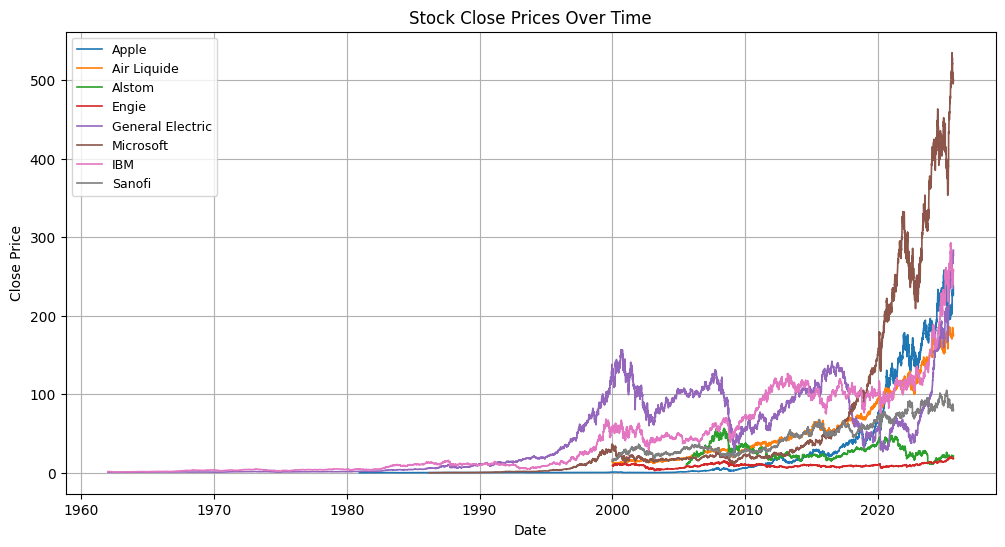

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load all datasets
datasets = {
    "Apple": pd.read_csv("stock_data/AAPL.csv"),
    "Air Liquide": pd.read_csv("stock_data/AI.PA.csv"),
    "Alstom": pd.read_csv("stock_data/ALO.PA.csv"),
    "Engie": pd.read_csv("stock_data/ENGI.PA.csv"),
    "General Electric": pd.read_csv("stock_data/GE.csv"),
    "Microsoft": pd.read_csv("stock_data/MSFT.csv"),
    "IBM": pd.read_csv("stock_data/IBM.csv"),
    "Sanofi": pd.read_csv("stock_data/SAN.PA.csv")
}

# Plot all stocks
plt.figure(figsize=(12, 6))

for name, df in datasets.items():
    df["Date"] = pd.to_datetime(df["Date"])
    df = df[["Date", "Close"]]  # keep only Date and Close
    plt.plot(df["Date"], df["Close"], label=name, linewidth=1.2)

# Chart formatting
plt.title("Stock Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)

# Legend inside the figure (upper left, but you can change loc)
plt.legend(loc="upper left", fontsize=9, frameon=True)

plt.show()



For prediction, we will consider data from 2000.

# Training

In [11]:
import pandas as pd
import numpy as np
import joblib
import os
import logging
from datetime import datetime
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


# Load environment variables
load_dotenv()


# Configure logging
logging.basicConfig(
level=logging.INFO,
format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

## Technical Indicator

#### **SMA : Simple Moving Average**
To determine the average price of an asset over a set number of periods, typically calculated using closing prices. Mean of data point given a set of data.
$$ SMA = \frac{\sum Ci}{n} $$

#### **EMA : Exponential Moving Average**
Same as SMA, but more recent data have more weight.
$EMA_t = \alpha \cdot P_t + (1 - \alpha) \cdot EMA_{t-1}$
where
$\alpha = \frac{2}{n+1}$,
$P_t$ = price at time $t$,
$n$ = lookback period.

#### **RSI : Relative Strength Index**
Measures the speed and magnitude of a security's recent price changes to detect overbought or oversold conditions in the price of that security.
$$ RSI_{t1} = 100 - \frac{100}{1 + avg_{gain}/avg_{loss}}$$
$$ RSI_{t2} = 100 - \frac{100}{1 + \frac{previous\_avg_{gain}*13 + Gain_{current}}{previous\_avg_{loss} *13 + Loss_{current}}}$$

#### **MACD : Moving Average Convergence Divergence**
Used to assess the power of price movement in a market.
$MACD = EMA_{12} - EMA_{26}$
Signal line (used for crossovers):
$Signal = EMA_{9}(MACD)$

#### **ATR : Average True Range**
Indicator that demonstrates market volatility. ATR shows the average range prices swing for an investment over a specified period.

1. First, calculate True Range (TR):
   $TR = \max \big( H - L, |H - C_{prev}|, |L - C_{prev}| \big)$
   where $H$ = high, $L$ = low, $C_{prev}$ = previous close.
2. Then, ATR = moving average of TR over $n$ periods:
   $ATR_n = \frac{1}{n} \sum_{i=1}^{n} TR_i$

#### **Bollinger Bands**

A volatility indicator consisting of a moving average (usually 20-period SMA) with two standard deviation bands plotted above and below it. Prices tend to stay within the bands, and moves outside them may indicate overbought/oversold conditions or volatility breakouts.

* **Middle Band** (MB):
  $MB = SMA_n$
* **Upper Band** (UB):
  $UB = MB + k \cdot \sigma_n$
* **Lower Band** (LB):
  $LB = MB - k \cdot \sigma_n$

where
$\sigma_n$ = standard deviation over $n$ periods,
$k$ = usually 2.



In [ ]:
class TechnicalIndicators:
    @staticmethod
    def calculate_sma(series, window):
        return series.rolling(window=window).mean()

    @staticmethod
    def calculate_ema(series, window):
        return series.ewm(span=window, adjust=False).mean()

    @staticmethod
    def calculate_rsi(series, window=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    @staticmethod
    def calculate_macd(series, fast=12, slow=26, signal=9):
        ema_fast = TechnicalIndicators.calculate_ema(series, fast)
        ema_slow = TechnicalIndicators.calculate_ema(series, slow)
        macd = ema_fast - ema_slow
        signal_line = TechnicalIndicators.calculate_ema(macd, signal)
        macd_hist = macd - signal_line
        return macd, signal_line, macd_hist

    @staticmethod
    def calculate_atr(high, low, close, window=14):
        tr = pd.DataFrame({
            'hl': high - low,
            'hc': abs(high - close.shift()),
            'lc': abs(low - close.shift())
        }).max(axis=1)
        return tr.rolling(window=window).mean()

    @staticmethod
    def calculate_bollinger_bands(series, window=20, num_std=2):
        sma = series.rolling(window=window).mean()
        rolling_std = series.rolling(window=window).std()
        upper = sma + (rolling_std * num_std)
        lower = sma - (rolling_std * num_std)
        percent_b = (series - sma) / (upper - lower)
        return upper, sma, lower, percent_b


def add_technical_indicators(df):
    TI = TechnicalIndicators()
    df['SMA_20'] = TI.calculate_sma(df['Close'], 20)
    df['SMA_50'] = TI.calculate_sma(df['Close'], 50)
    df['EMA_20'] = TI.calculate_ema(df['Close'], 20)
    df['RSI_14'] = TI.calculate_rsi(df['Close'])
    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = TI.calculate_macd(df['Close'])
    df['Upper_BB'], df['Middle_BB'], df['Lower_BB'], df['Percent_B'] = TI.calculate_bollinger_bands(df['Close'])
    df['ATR_14'] = TI.calculate_atr(df['High'], df['Low'], df['Close'])
    df['OBV'] = (np.sign(df['Close'].diff().fillna(0)) * df['Volume']).cumsum()

    # Rolling stats for momentum
    for window in [3, 5, 10]:
        df[f'Close_mean_{window}'] = df['Close'].rolling(window).mean()
        df[f'Close_std_{window}'] = df['Close'].rolling(window).std()
        df[f'Volume_mean_{window}'] = df['Volume'].rolling(window).mean()
        df[f'Volume_std_{window}'] = df['Volume'].rolling(window).std()

    # DO NOT drop NaNs here
    return df


## Data Preparation

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

# Load CSV
df = pd.read_csv("stock_data/GE.csv")

# Compute mid prices
high_prices = df['High'].values
low_prices = df['Low'].values
mid_prices = (high_prices + low_prices) / 2.0

# Split into train/test
train_size = int(0.8 * len(mid_prices))
train_data = mid_prices[:train_size]
test_data = mid_prices[train_size:]

# Reshape for scaler
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Windowed normalization
scaler = MinMaxScaler()
smoothing_window_size = 2500

for di in range(0, len(train_data), smoothing_window_size):
    if di + smoothing_window_size > len(train_data):
        scaler.fit(train_data[di:])
        train_data[di:] = scaler.transform(train_data[di:])
    else:
        scaler.fit(train_data[di:di+smoothing_window_size])
        train_data[di:di+smoothing_window_size] = scaler.transform(train_data[di:di+smoothing_window_size])

# Reshape train data back to 1D
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)


MSE error for standard averaging: 0.00377


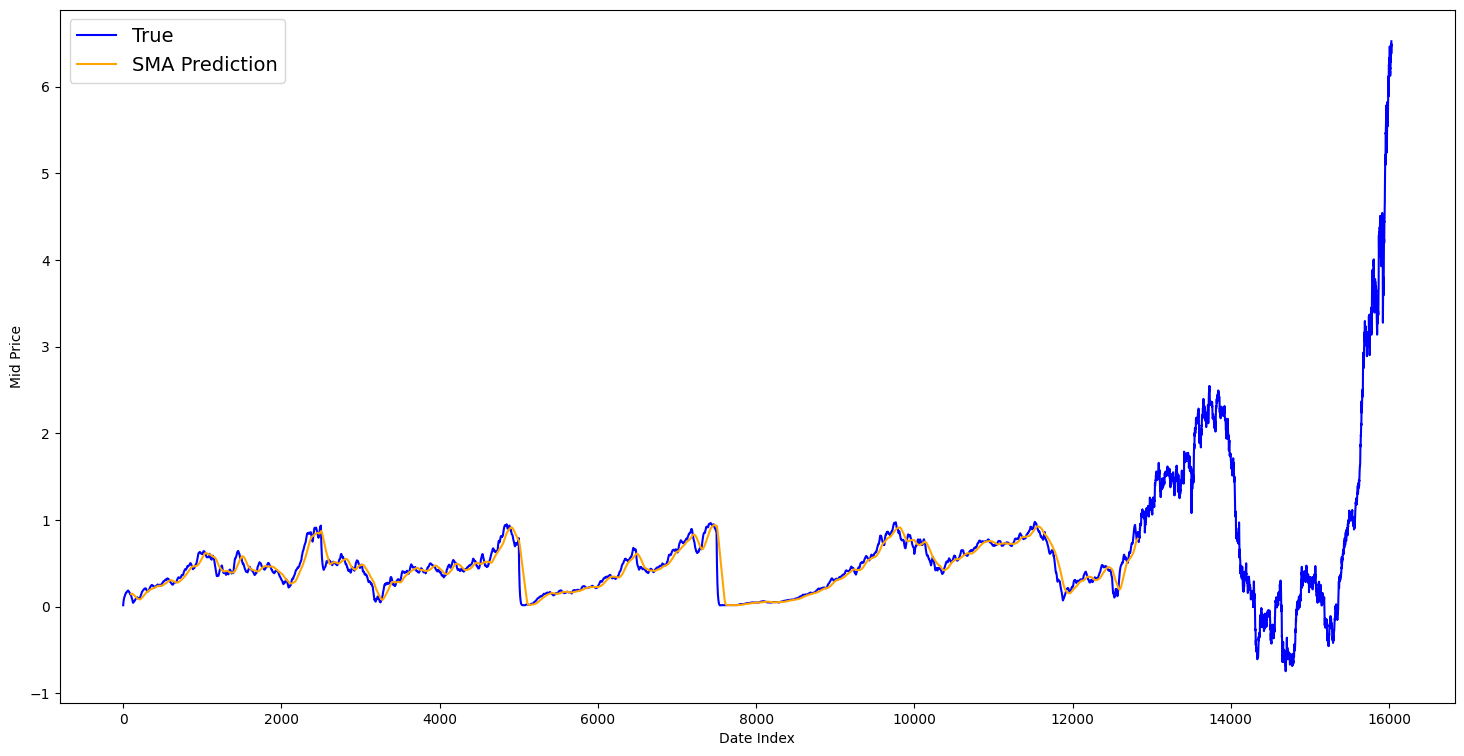

In [110]:
# EMA smoothing of training data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Concatenate train + test for visualization
all_mid_data = np.concatenate([train_data, test_data], axis=0)

# ---------- Standard averaging (SMA) ----------
window_size = 100
N = len(train_data)

std_avg_predictions = []
mse_errors_sma = []

for pred_idx in range(window_size, N):
    pred = np.mean(train_data[pred_idx-window_size:pred_idx])
    std_avg_predictions.append(pred)
    mse_errors_sma.append((pred - train_data[pred_idx])**2)

print('MSE error for standard averaging: %.5f' % (0.5*np.mean(mse_errors_sma)))

# Plot SMA
plt.figure(figsize=(18,9))
plt.plot(range(len(all_mid_data)), all_mid_data, color='b', label='True')
plt.plot(range(window_size, N), std_avg_predictions, color='orange', label='SMA Prediction')
plt.xlabel('Date Index')
plt.ylabel('Mid Price')
plt.legend(fontsize=14)
plt.show()

### EMA : Exponential moving average

MSE error for EMA averaging: 0.00003


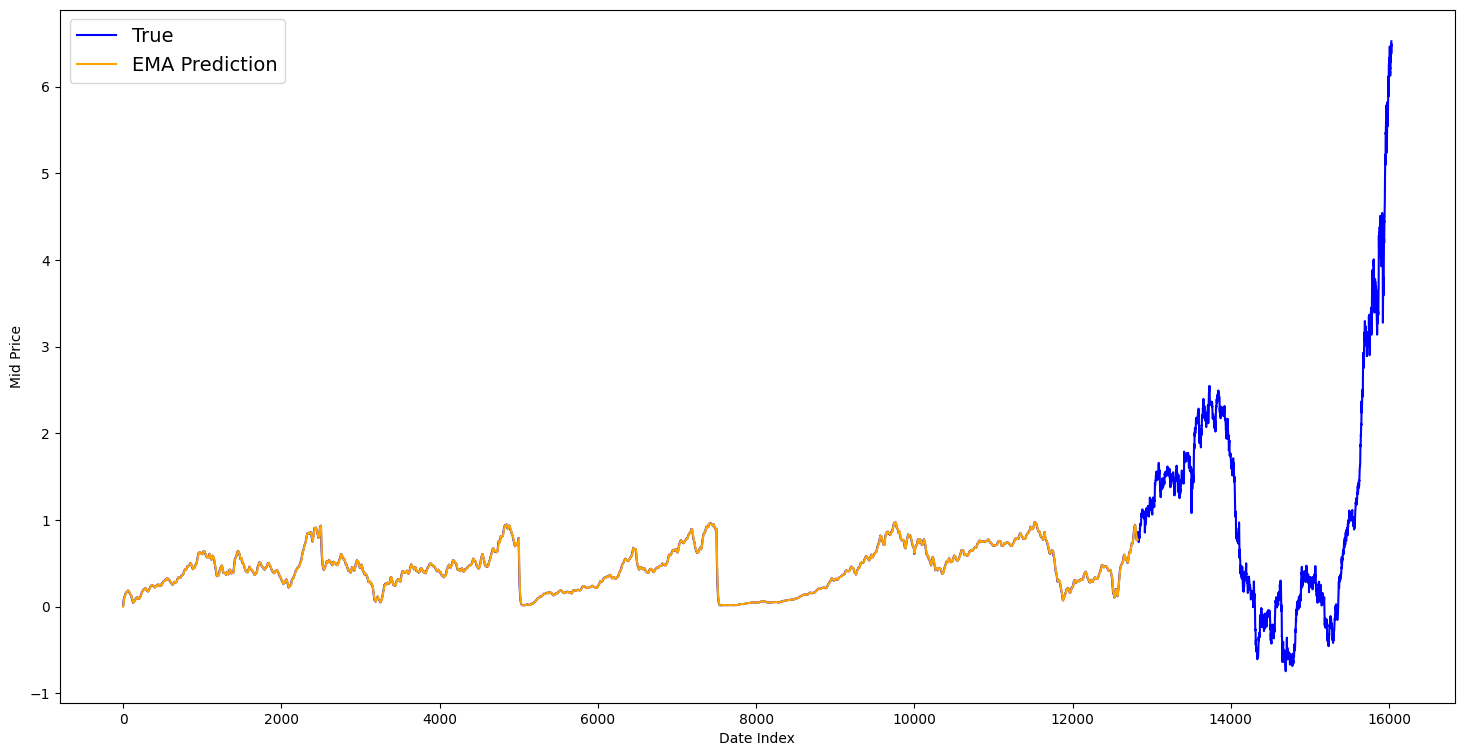

In [111]:
decay = 0.5
run_avg_predictions = []
mse_errors_ema = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

for pred_idx in range(1, N):
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors_ema.append((running_mean - train_data[pred_idx])**2)

print('MSE error for EMA averaging: %.5f' % (0.5*np.mean(mse_errors_ema)))

# Plot EMA averaging
plt.figure(figsize=(18,9))
plt.plot(range(len(all_mid_data)), all_mid_data, color='b', label='True')
plt.plot(range(0, N), run_avg_predictions, color='orange', label='EMA Prediction')
plt.xlabel('Date Index')
plt.ylabel('Mid Price')
plt.legend(fontsize=14)
plt.show()

# LSTMs : Predict more than just the next day

**Long short term memory**

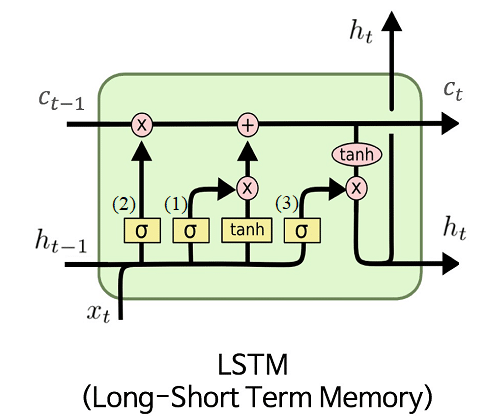

Long-Short-Term Memory (LSTM) models are extremely powerful time-series models. They can predict an arbitrary number of steps into the future.

An LSTM cell has the following components:
- **Cell state ($c_t$)**: stores long-term and short-term memory
- **Hidden state ($h_t$)**: output state, used to predict future prices
- **Input gate ($i_t$)**: controls how much of current input flows to the cell state
- **Forget gate ($f_t$)**: controls how much of previous memory is retained
- **Output gate ($o_t$)**: controls what flows into the hidden state

Equations:

$$i_t = σ(W_ix * X_t + W_ih * h_{t-1} + b_i)$$
$$𝑐̃_t = tanh(W_cx * X_t + W_ch * h_{t-1} + b_c)$$
$$f_t = σ(W_fx * X_t + W_fh * h_{t-1} + b_f)$$
$$c_t = f_t * c_{t-1} + i_t * 𝑐̃_t$$
$$o_t = σ(W_ox * X_t + W_oh * h_{t-1} + b_o)$$
$$h_t = o_t * tanh(c_t)$$

## Train LSTM

\\wsl.localhost\Ubuntu\home\ambroise012\Projet_prediction_stocks\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 6.3084e-04
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.6398e-05
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.6280e-05
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.1086e-05
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.6600e-05
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.3979e-05
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.1617e-05
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.7849e-05
Epoch 9/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.4894e-05
Epoch 10/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.5356e-05
Epoch 11/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.4474e-05
Epoch 12/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.1979e-05
Epoch 13/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.9772e-05
Epoch 14/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss

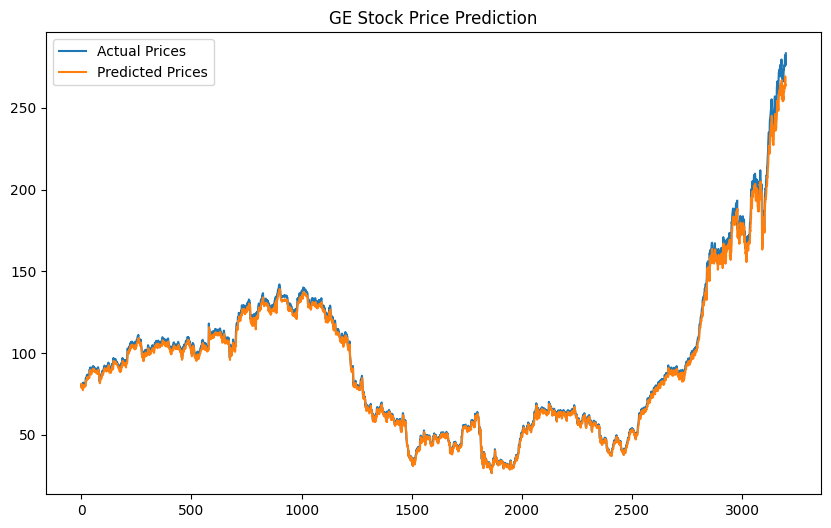

MSE error for LSTM : 10.39016


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# ticker 
ticker = "GE"

# Load and preprocess data
df = pd.read_csv(f"stock_data/{ticker}.csv")

close_values = df['Close'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_values).flatten()

# Function to create dataset with look_back window
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back)])
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# Create dataset with look_back window
look_back = 30
X, Y = create_dataset(scaled_values, look_back=look_back)

# Split dataset into training and testing sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Reshape data for the LSTM Model [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(look_back, 1)))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Train model
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1)

# Predict on test set
predictions = model.predict(testX)

# Inverse transform predictions and true values
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(testY.reshape(-1, 1))

# Plot results
plt.figure(figsize=(10,6))
plt.plot(actual, label="Actual Prices")
plt.plot(predictions, label="Predicted Prices")
plt.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.show()

# compute MSE of LSTM
mse = mean_squared_error(actual, predictions)
print('MSE error for LSTM : %.5f' % mse)


predict the next days

In [7]:
last_30_days = scaled_values[-look_back:]        # take last 30 days
last_30_days = np.reshape(last_30_days, (1, look_back, 1))  

next_day_scaled = model.predict(last_30_days)   # scaled prediction
next_day_price = scaler.inverse_transform(next_day_scaled)  # convert back

print(f"Predicted next day price: {next_day_price[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Predicted next day price: 270.3795


In [8]:
predictions_scaled = []
last_sequence = scaled_values[-look_back:].reshape(1, look_back, 1)

for _ in range(7):  # predict 7 days
    next_scaled = model.predict(last_sequence)  # shape (1, 1)
    predictions_scaled.append(next_scaled[0,0])
    
    # reshape prediction to (1,1,1) so it matches last_sequence
    next_scaled = next_scaled.reshape(1, 1, 1)
    
    # update the sequence: drop first, add new prediction
    last_sequence = np.concatenate([last_sequence[:,1:,:], next_scaled], axis=1)

# Inverse transform predictions
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1,1))

print("Predicted prices for the next 7 days:")
print(predictions.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted prices for the next 7 days:
[270.37952 256.1056  246.648   238.05463 230.21198 223.09334 216.59853]


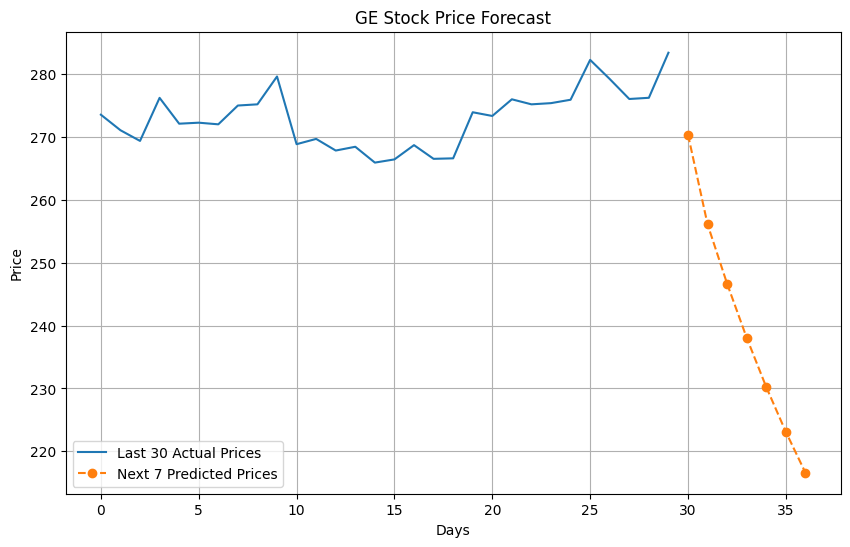

In [9]:
last_30_actual = close_values[-look_back:]  # last 30 actual prices
future_days = np.arange(len(last_30_actual), len(last_30_actual) + 7)

plt.figure(figsize=(10,6))
plt.plot(range(len(last_30_actual)), last_30_actual, label="Last 30 Actual Prices")
plt.plot(future_days, predictions, marker='o', linestyle='--', label="Next 7 Predicted Prices")

plt.title("GE Stock Price Forecast")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


## Improvement


\\wsl.localhost\Ubuntu\home\ambroise012\Projet_prediction_stocks\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.1042e-04 - val_loss: 3.8324e-04
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.5936e-05 - val_loss: 2.2078e-04
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.2040e-05 - val_loss: 2.0414e-04
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.5701e-05 - val_loss: 2.0246e-04
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.5038e-05 - val_loss: 1.2653e-04
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.1537e-05 - val_loss: 1.3283e-04
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.7943e-05 - val_loss: 1.1937e-04
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.5456e-05 - val_loss: 9.0753e-05
Epoch 9/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.5179e-05 - val_loss: 1.0368e-04
Epoch 10/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.2952e-05 - val_loss: 9.5234e-05
Epoch 11/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s

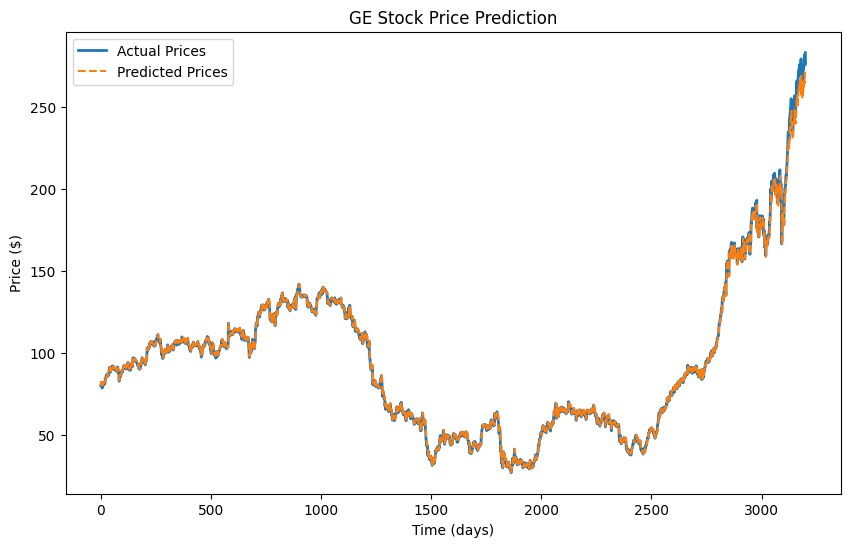

MSE error for LSTM : 5.41406
RMSE error for LSTM : 2.32681


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# =========================
# Parameters
# =========================
ticker = "GE"
look_back = 30
epochs = 100
batch_size = 32

# =========================
# Load and preprocess data
# =========================
df = pd.read_csv(f"stock_data/{ticker}.csv")

# Use only the 'Close' column
close_values = df[['Close']].values  # shape (n_samples, 1)

# Normalize between 0 and 1
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_values)

# =========================
# Create sequences
# =========================
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])  # sequence of past look_back values
        Y.append(dataset[i + look_back, 0])      # value to predict
    return np.array(X), np.array(Y)

X, Y = create_dataset(scaled_values, look_back)

# =========================
# Train-test split
# =========================
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Reshape input to [samples, time steps, features]
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

# =========================
# Build LSTM model
# =========================
model = Sequential([
    LSTM(50, input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# =========================
# Train model
# =========================
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(testX, testY))

# =========================
# Make predictions
# =========================
predictions = model.predict(testX)

# Inverse transform predictions and true values
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(testY.reshape(-1, 1))

# =========================
# Plot results
# =========================
plt.figure(figsize=(10,6))
plt.plot(actual, label="Actual Prices", linewidth=2)
plt.plot(predictions, label="Predicted Prices", linestyle="--")
plt.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Time (days)")
plt.ylabel("Price ($)")
plt.show()

# =========================
# Evaluate model
# =========================
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
print(f"MSE error for LSTM : {mse:.5f}")
print(f"RMSE error for LSTM : {rmse:.5f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Predicted next day price: 272.2774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted prices for the next 7 days:
[272.27744 260.35538 253.99976 246.96579 241.38918 236.4375  232.06253]


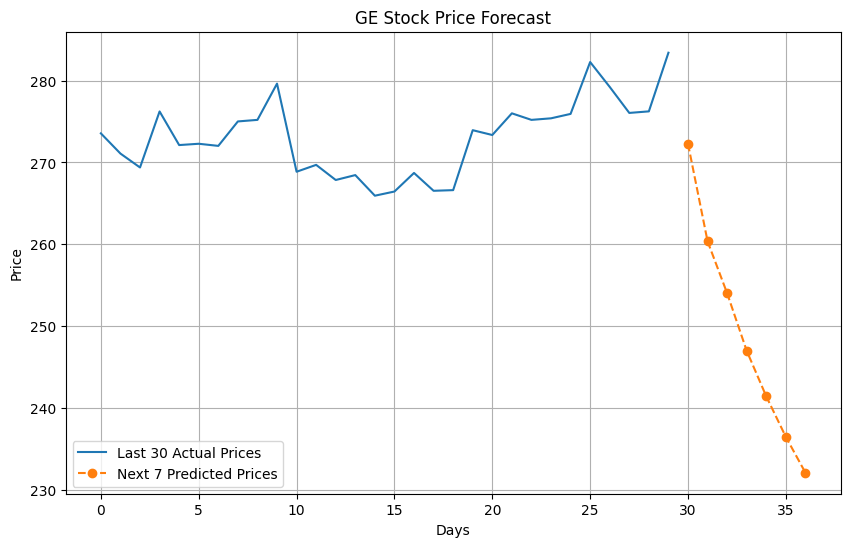

In [12]:
# DAY + 1
last_30_days = scaled_values[-look_back:]        # take last 30 days
last_30_days = np.reshape(last_30_days, (1, look_back, 1))  

next_day_scaled = model.predict(last_30_days)   # scaled prediction
next_day_price = scaler.inverse_transform(next_day_scaled)  # convert back

print(f"Predicted next day price: {next_day_price[0][0]:.4f}")

# DAY + 7
predictions_scaled = []
last_sequence = scaled_values[-look_back:].reshape(1, look_back, 1)

for _ in range(7):  # predict 7 days
    next_scaled = model.predict(last_sequence)  # shape (1, 1)
    predictions_scaled.append(next_scaled[0,0])
    
    # reshape prediction to (1,1,1) so it matches last_sequence
    next_scaled = next_scaled.reshape(1, 1, 1)
    
    # update the sequence: drop first, add new prediction
    last_sequence = np.concatenate([last_sequence[:,1:,:], next_scaled], axis=1)

# Inverse transform predictions
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1,1))

print("Predicted prices for the next 7 days:")
print(predictions.flatten())

last_30_actual = close_values[-look_back:]  # last 30 actual prices
future_days = np.arange(len(last_30_actual), len(last_30_actual) + 7)

plt.figure(figsize=(10,6))
plt.plot(range(len(last_30_actual)), last_30_actual, label="Last 30 Actual Prices")
plt.plot(future_days, predictions, marker='o', linestyle='--', label="Next 7 Predicted Prices")

plt.title("GE Stock Price Forecast")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# =========================
# Parameters
# =========================
ticker = "AAPL"
look_back = 30
epochs = 100
batch_size = 32
future_days = 5  # number of days to predict beyond last date

# =========================
# Load and preprocess data
# =========================
df = pd.read_csv(f"stock_data/{ticker}.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df[["Date", "Close"]]

# Keep last 30 days for plotting
df_plot = df.tail(30).copy()

# Prepare LSTM dataset
close_values = df[['Close']].values
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_values)

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X, Y = create_dataset(scaled_values, look_back)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, shuffle=False)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

# =========================
# Load and preprocess data
# =========================
df = pd.read_csv(f"stock_data/{ticker}.csv")
close_values = df[['Close']].values
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_values)

# =========================
# Create sequences
# =========================
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X, Y = create_dataset(scaled_values, look_back)

# =========================
# Train-test split
# =========================
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, shuffle=False)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

# =========================
# Build LSTM model
# =========================
model = Sequential([
    LSTM(50, input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

# =========================
# Train model
# =========================
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(testX, testY))

# =========================
# Forecast future days
# =========================
last_sequence = scaled_values[-look_back:].reshape(1, look_back, 1)
future_predictions = []

for _ in range(future_days):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0,0])
    last_sequence = np.append(last_sequence[:,1:,:], [[next_pred]], axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
future_dates = [df["Date"].iloc[-1] + pd.Timedelta(days=i+1) for i in range(future_days)]

# =========================
# Plot everything
# =========================
plt.figure(figsize=(12,6))
plt.plot(df_plot["Date"], df_plot["Close"], label="Last 30 Days Actual", linewidth=2)
plt.plot(range(len(df_plot), len(df_plot)+len(predictions)), predictions, label="Test Predictions", linestyle="--")
plt.plot(future_dates, future_predictions, label="Future Forecast", linestyle="--", color="red")
plt.title(f"{ticker} Stock Price - Last 30 Days + Predictions")
plt.xlabel("Date / Time Index")
plt.ylabel("Close Price ($)")
plt.grid(True)
plt.legend()
plt.show()


\\wsl.localhost\Ubuntu\home\ambroise012\Projet_prediction_stocks\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.6801e-04 - val_loss: 1.7246e-04
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.8388e-05 - val_loss: 1.8248e-04
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.3511e-05 - val_loss: 1.1050e-04
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.2369e-05 - val_loss: 1.1532e-04
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 2.8743e-05 - val_loss: 9.8851e-05
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.6019e-05 - val_loss: 1.0014e-04
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.4716e-05 - val_loss: 9.2180e-05
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.3158e-05 - val_loss: 1.6456e-04
Epoch 9/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.2551e-05 - val_loss: 8.6156e-05
Epoch 10/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.0295e-05 - val_loss: 6.8015e-05
Epoch 11/100
400/400 ━━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 